# VERSION 002

In [1]:
#firstly i'll import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split ,GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer , CountVectorizer
from sklearn import svm 
from sklearn.metrics import RocCurveDisplay , accuracy_score,f1_score
from sklearn.preprocessing import StandardScaler ,RobustScaler , Normalizer


In [2]:
test_titanic = pd.read_csv("../test.csv") #loading test data
train_titanic = pd.read_csv("../train.csv") #loading train data
display(test_titanic.head())
display(train_titanic.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
display(train_titanic.shape)
display(test_titanic.shape)

(891, 12)

(418, 11)

In [4]:
train_titanic.info() # checking any missing data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


As we can see there are missing data in age,embarked and cabin data. I'll fill age missing values with means of the age and embarked to the most frequent embarked symbol

<Axes: xlabel='Age', ylabel='Density'>

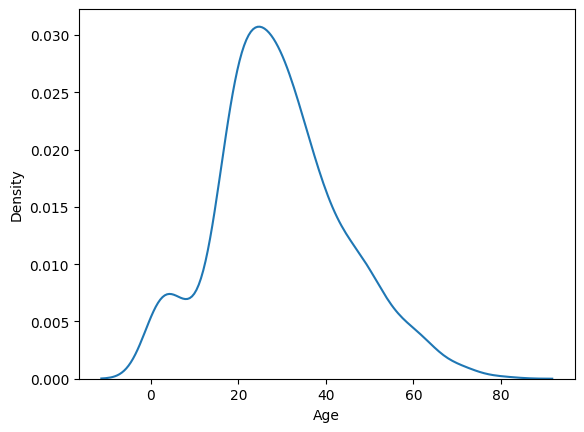

In [5]:
sns.kdeplot(train_titanic.Age) 

we can see that distribution of age is not unimodal. we can understand by looking the bump between 0 and 20
this information can be used to make a "AGE_GAP" column. (putting ages 0-18 in same category)

In [6]:
train_titanic = train_titanic.drop_duplicates() #dropping any duplicated rows if they exist
display(train_titanic.shape) #checking if any rows are dropped

(891, 12)

In [7]:
mean = train_titanic['Age'].mean() #calculating mean of the age 
train_titanic["Age"].replace(np.nan,mean,inplace=True) #replacing missing rows with mean
mode = train_titanic["Embarked"].describe()
display(mode) #after verifyn that most freq was S i will put S. (it is important to consider other values as well)
train_titanic["Embarked"].replace(np.nan, "S",inplace=True)


count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

cabin column has lots of missing data i'll drop it for now.

In [8]:
train_titanic.drop(columns="Cabin",axis=1,inplace=True)

In [9]:
train_titanic.isna().sum().to_dict() #checking if it has replaced the missing values

{'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 0,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Embarked': 0}

In [10]:
#to describe anomalies i need to use a loop
columns = train_titanic.columns
for column in columns:
    display(train_titanic[column].describe())

count    891.000000
mean     446.000000
std      257.353842
min        1.000000
25%      223.500000
50%      446.000000
75%      668.500000
max      891.000000
Name: PassengerId, dtype: float64

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

count    891.000000
mean       2.308642
std        0.836071
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        3.000000
Name: Pclass, dtype: float64

count                         891
unique                        891
top       Braund, Mr. Owen Harris
freq                            1
Name: Name, dtype: object

count      891
unique       2
top       male
freq       577
Name: Sex, dtype: object

count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

count     891
unique      3
top         S
freq      646
Name: Embarked, dtype: object

In [11]:
# using count vectorizer might be helpful

#train_titanic["Name"] = train_titanic["Name"].str.lower() #lowering the letters

In [12]:
train_titanic['FamilySize'] = train_titanic['SibSp'] + train_titanic['Parch'] + 1
train_titanic['Title']=train_titanic.Name.str.extract('([A-Za-z]+)\.')
train_titanic['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col',
                         'Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)


In [13]:
# a.reshape(1,-1)
# a = a.transpose()
# df_a = pd.DataFrame(a)

# df_a.rename(columns={0:"INVERSE_COUNT"},inplace=True)
# df_a.head()

# train_titanic = pd.concat([df_a,train_titanic],axis=1)

In [14]:
# train_titanic["INVERSE_COUNT"].describe()

In [15]:
#train_titanic[train_titanic["Counts"]==14] #to check if it works properly

In [16]:
train_titanic["Title"].describe()

count     891
unique      5
top        Mr
freq      529
Name: Title, dtype: object

In [17]:
#creating feature sets
def are_they_rich(data):
    if data == 1:
        return 3
    if data == 2:
        return 2
    if data == 3:
        return 1
train_titanic["ARE_THEY_RICH"] = train_titanic["Pclass"].map(lambda x : are_they_rich(x))

def are_they_child(data):
    if (data >= 0) and (data <=18):
        return 1
    else:
        return 0

train_titanic["ARE_THEY_CHILD"] = train_titanic["Age"].map(lambda x : are_they_child(x))


train_titanic["Pclass"] = train_titanic["Pclass"].astype("object")


features_num = [column for column in train_titanic.columns if train_titanic[column].dtype in ["int64","float64"]]
features_cat = ["Sex","Embarked","Pclass","Title"] #these are the categorical features for now 
display(features_num)
X = pd.get_dummies(train_titanic[features_cat])
X = pd.concat([X,train_titanic[features_num]], axis=1)

X.info()



['PassengerId',
 'Survived',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'FamilySize',
 'ARE_THEY_RICH',
 'ARE_THEY_CHILD']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex_female      891 non-null    uint8  
 1   Sex_male        891 non-null    uint8  
 2   Embarked_C      891 non-null    uint8  
 3   Embarked_Q      891 non-null    uint8  
 4   Embarked_S      891 non-null    uint8  
 5   Pclass_1        891 non-null    uint8  
 6   Pclass_2        891 non-null    uint8  
 7   Pclass_3        891 non-null    uint8  
 8   Title_Master    891 non-null    uint8  
 9   Title_Miss      891 non-null    uint8  
 10  Title_Mr        891 non-null    uint8  
 11  Title_Mrs       891 non-null    uint8  
 12  Title_Other     891 non-null    uint8  
 13  PassengerId     891 non-null    int64  
 14  Survived        891 non-null    int64  
 15  Age             891 non-null    float64
 16  SibSp           891 non-null    int64  
 17  Parch           891 non-null    int

/var/folders/bl/r2644t156ysdhnf63_n5zlbr0000gn/T/ipykernel_60796/1591932802.py:26: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  X = pd.get_dummies(train_titanic[features_cat])


In [18]:
#instead of using one hot encoding for pclass you can use ordinal encoding because there is a relation with 1st and second and third
# pclass: A proxy for socio-economic status (SES)
# 1st = Upper
# 2nd = Middle
# 3rd = Lower

In [19]:
#normalizer = # normalizing our data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
y = X.Survived

X = X.drop(columns="Survived",axis=1) #setting target feature

X = RobustScaler().fit_transform(X) #i can play with various scaling methods

train_x, test_x, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state=1)


In [20]:
y.shape

(891,)

In [21]:
X.shape

(891, 21)

In [22]:
# at first i will try svm
model_1 = svm.SVC(kernel="poly")
model_1.fit(train_x,train_y)
preds = model_1.predict(test_x)

display(accuracy_score(preds,test_y)) 

0.7686567164179104

In [23]:
#as second model i will use a decision tree

model_2 = DecisionTreeClassifier()
model_2.fit(train_x,train_y)

preds = model_2.predict(test_x)

display(accuracy_score(preds,test_y))

0.7238805970149254

In [24]:
#as third model i will use knn

model_3 = KNeighborsClassifier().fit(train_x,train_y)
preds = model_3.predict(test_x)

display(accuracy_score(preds,test_y))


0.7835820895522388

In [25]:
train_titanic["ARE_THEY_CHILD"].describe()

count    891.000000
mean       0.156004
std        0.363063
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: ARE_THEY_CHILD, dtype: float64

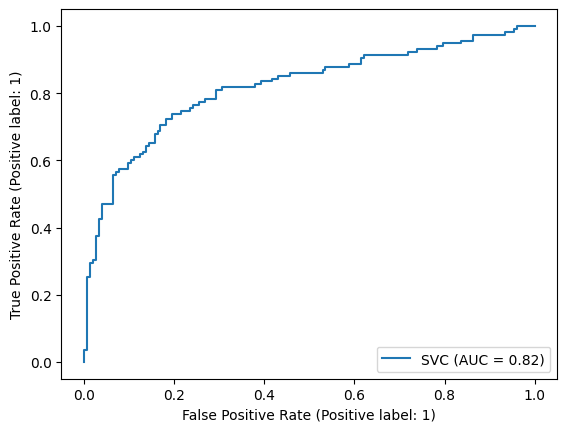

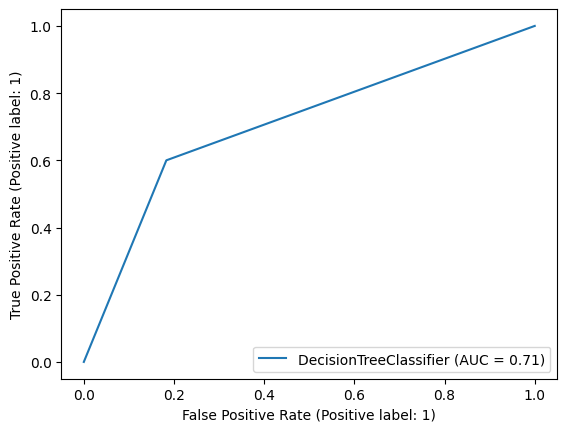

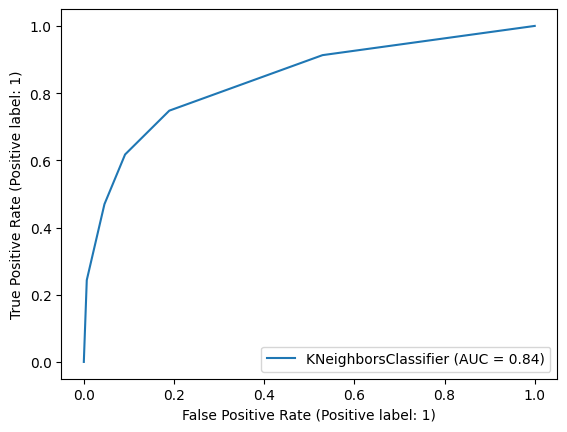

In [26]:
models=[model_1,model_2,model_3]
for model in models:
    RocCurveDisplay.from_estimator(model,test_x,test_y)
    plt.show()

In [27]:
model_1.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [28]:
#in terms of robustness kneighbours classifier and svc seems to be doing a good job without data adjustments and without hyperparameter tuning
#possible values of parameters of the first model
params_1 = {
    "C": np.linspace(3.5,4,num=5),
    "kernel":["linear", "poly", "rbf", "sigmoid"],
    "probability":[True,False],
    "gamma":["scale","auto"],
    "class_weight":["balanced",None],
    "random_state":[1]
}

model_cv = GridSearchCV(model_1,params_1,refit=True,n_jobs=-1,cv=30,verbose=2)
model_cv.fit(X,y)

Fitting 30 folds for each of 160 candidates, totalling 4800 fits


[CV] END C=3.5, class_weight=balanced, gamma=scale, kernel=linear, probability=True, random_state=1; total time=   0.2s
[CV] END C=3.5, class_weight=balanced, gamma=scale, kernel=linear, probability=True, random_state=1; total time=   0.2s
[CV] END C=3.5, class_weight=balanced, gamma=scale, kernel=linear, probability=True, random_state=1; total time=   0.2s
[CV] END C=3.5, class_weight=balanced, gamma=scale, kernel=linear, probability=True, random_state=1; total time=   0.2s
[CV] END C=3.5, class_weight=balanced, gamma=scale, kernel=linear, probability=True, random_state=1; total time=   0.2s
[CV] END C=3.5, class_weight=balanced, gamma=scale, kernel=linear, probability=True, random_state=1; total time=   0.2s
[CV] END C=3.5, class_weight=balanced, gamma=scale, kernel=linear, probability=True, random_state=1; total time=   0.2s
[CV] END C=3.5, class_weight=balanced, gamma=scale, kernel=linear, probability=True, random_state=1; total time=   0.2s
[CV] END C=3.5, class_weight=balanced, g

GridSearchCV(cv=30, estimator=SVC(kernel='poly'), n_jobs=-1,
             param_grid={'C': array([3.5  , 3.625, 3.75 , 3.875, 4.   ]),
                         'class_weight': ['balanced', None],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'probability': [True, False], 'random_state': [1]},
             verbose=2)

In [29]:
display(model_cv.best_estimator_)
display(model_cv.best_score_)

SVC(C=3.5, gamma='auto', probability=True, random_state=1)

0.8362452107279694

In [30]:
#possible parameters for the knn algorithm

params_3 = {
    "weights":["uniform","distance"],
    "algorithm":["auto", "ball_tree", "kd_tree", "brute"],
    "p":[1,2,1.5],
    "n_neighbors":[20,30,100,150],

}
knn_cv = GridSearchCV(model_3,params_3,refit=True,n_jobs=-1,cv=30,verbose=1)
knn_cv.fit(train_x,train_y)

Fitting 30 folds for each of 96 candidates, totalling 2880 fits


GridSearchCV(cv=30, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [20, 30, 100, 150], 'p': [1, 2, 1.5],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [31]:
display(knn_cv.best_estimator_)
display(knn_cv.best_score_)

KNeighborsClassifier(n_neighbors=20, p=1)

0.8426190476190476

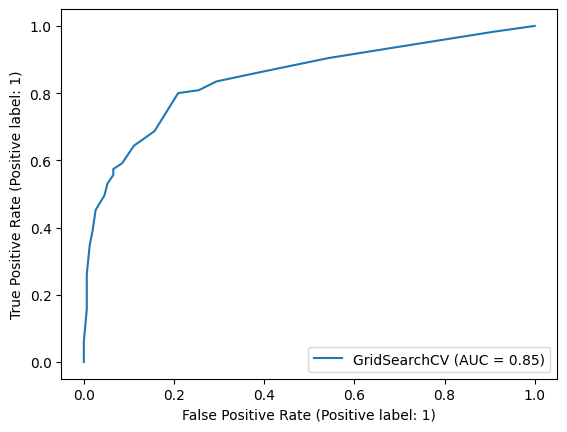

In [32]:
RocCurveDisplay.from_estimator(knn_cv,test_x,test_y)
plt.show()

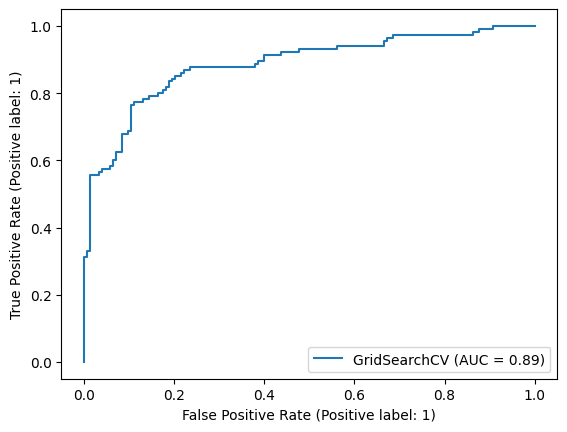

In [33]:
RocCurveDisplay.from_estimator(model_cv,test_x,test_y)
plt.show()

## now with these results applying these feature engineering to test data 


In [34]:
test_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


#### trying random forest classifier this time

In [35]:
from sklearn.ensemble import RandomForestClassifier
rand_f = RandomForestClassifier(class_weight='balanced_subsample') 
rand_f.fit(X,y) 

RandomForestClassifier(class_weight='balanced_subsample')

In [36]:
#we need to change missing columns
test_titanic["Age"].replace(np.nan,mean,inplace=True)
test_titanic["Fare"].replace(np.nan,test_titanic["Fare"].mean(),inplace=True)

test_titanic["ARE_THEY_RICH"] = test_titanic["Pclass"].map(lambda x : are_they_rich(x))
test_titanic["Pclass"] = test_titanic["Pclass"].astype("object")

test_titanic["ARE_THEY_CHILD"] = test_titanic["Age"].map(lambda x : are_they_child(x))

#test_titanic["Counts"] = test_titanic["Name"].map(lambda x : count_words(x))


test_titanic['FamilySize'] = test_titanic['SibSp'] + test_titanic['Parch'] + 1
test_titanic['Title']=test_titanic.Name.str.extract('([A-Za-z]+)\.')
test_titanic['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col',
                         'Rev','Capt','Sir','Don',"Dona"],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr',"Mr"],inplace=True)

features_num = [column for column in test_titanic.columns if test_titanic[column].dtype in ["int64","float64"]]
features_cat = ["Sex","Embarked","Pclass","Title"] #these are the categorical features for now 
display(features_num)
X = pd.get_dummies(test_titanic[features_cat])
X = pd.concat([X,test_titanic[features_num]], axis=1)

display(X.info())
X = RobustScaler().fit_transform(X)

subission_preds = knn_cv.predict(X)

output = pd.DataFrame({'PassengerId': test_titanic.PassengerId,
                       'Survived': subission_preds})
output.to_csv('submission.csv', index=False)

['PassengerId',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'ARE_THEY_RICH',
 'ARE_THEY_CHILD',
 'FamilySize']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex_female      418 non-null    uint8  
 1   Sex_male        418 non-null    uint8  
 2   Embarked_C      418 non-null    uint8  
 3   Embarked_Q      418 non-null    uint8  
 4   Embarked_S      418 non-null    uint8  
 5   Pclass_1        418 non-null    uint8  
 6   Pclass_2        418 non-null    uint8  
 7   Pclass_3        418 non-null    uint8  
 8   Title_Master    418 non-null    uint8  
 9   Title_Miss      418 non-null    uint8  
 10  Title_Mr        418 non-null    uint8  
 11  Title_Mrs       418 non-null    uint8  
 12  Title_Other     418 non-null    uint8  
 13  PassengerId     418 non-null    int64  
 14  Age             418 non-null    float64
 15  SibSp           418 non-null    int64  
 16  Parch           418 non-null    int64  
 17  Fare            418 non-null    flo

/var/folders/bl/r2644t156ysdhnf63_n5zlbr0000gn/T/ipykernel_60796/411356567.py:21: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  X = pd.get_dummies(test_titanic[features_cat])


None

In [37]:
y_predictions = rand_f.predict(X) 
output = pd.DataFrame({'PassengerId':test_titanic.PassengerId, 'Survived': y_predictions}) 
output.to_csv('submission.csv', index=False)